# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





<font color=purple> **Before I get started, I want to note that most of the code in this colab notebook is taken from the lab notebook 'Topic_Modeling_tomotopy' from Week 6 of the course Analyzing Data.**

## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [1]:
# First install our necessary libraries
!pip install tomotopy
!pip install little_mallet_wrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 36.9 MB/s eta 0:00:00


In [2]:
# Secondly, import all the necessary libraries
import tomotopy as tp # a Python extension for topic modeling, includes LDA
import little_mallet_wrapper # a Python wrapper around the topic modeling functions of MALLET.
import seaborn # used for visualization
import glob # for working with files
from pathlib import Path # for working with the file system
import pandas as pd # used for data wrangling
import re # regular expressions library re in Python, allows us to work with these regular expressions, and for this notebook to find and replace the correct words.

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read and name the file for further use
trump_tweets = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/A3_analyzing_data/trump_tweets.csv')
sanders_tweets = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/A3_analyzing_data/sanders_tweets.csv')


# Combine the two datasets using the panda function concat
trump_sanders_tweets = pd.concat([trump_tweets, sanders_tweets])

In [5]:
# Save the csv to computer's working directory
trump_sanders_tweets.to_csv('trump_sanders_tweets.csv')

In [67]:
# Show the first few lines of the combined dataset for inspection
trump_sanders_tweets.head()

,Username,TweetId,Title,Content
0,@realDonaldTrump,822421390125043713,@realDonaldTrump_822421390125043713,It all begins today! I will see you at 11:00 ...
1,@realDonaldTrump,822501803615014918,@realDonaldTrump_822501803615014918,Today we are not merely transferring power fr...
2,@realDonaldTrump,822501939267141634,@realDonaldTrump_822501939267141634,"power from Washington, D.C. and giving it bac..."
3,@realDonaldTrump,822502135233384448,@realDonaldTrump_822502135233384448,What truly matters is not which party control...
4,@realDonaldTrump,822502270503972872,@realDonaldTrump_822502270503972872,"January 20th 2017, will be remembered as the ..."


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [6]:
# Get an overview about the dataset we just created, such as the columns and different datatypes in the dataframe
trump_sanders_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30371 entries, 0 to 7295
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Username  30371 non-null  object
 1   TweetId   30371 non-null  int64 
 2   Title     30371 non-null  object
 3   Content   30371 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [52]:
# Make three empty list, one to add our cleaned training data to, one to add our original Tweet content to, and one to add the author and Tweet ID to
training_data = []
original_texts = []
titles = []

# We make an empty list and iterate through every row, we then select the column that contains the actual tweets, process this texts, and finally append them to the previously empty training_data list.
# We also add the 'Content' to the original_texts list and the 'Username' and 'TweetId' to the titles list
for index, row in trump_sanders_tweets.iterrows():
    tweet_text = row['Content']
    # We use little_mallet_wrapper to transform all the text to lowercase, remove stopwords, punctuation, and numbers.
    processed_text = little_mallet_wrapper.process_string(tweet_text, numbers='remove')
    # Tip: add the following line to remove URLS and user mentions
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', processed_text, flags=re.MULTILINE)
    # Add the processed text to our master list training_data
    training_data.append(processed_text)
    # Add the content of the tweet to our list original_texts
    original_texts.append(tweet_text)
    # And finally, add the author of the tweet and its ID to our list titles, which are combined in the column 'Title'
    titles.append(row['Title'])

## LDA topic modelling

<font color=purple> **Below you will find 5 different LDA topic models trained with different numbers of topics. I have saved all of these and left them in this notebook for a clear documentation of what I did, but also to showcase how I ended up choosing the model to further work with. So for each of those models, I have written out both questions 4 and 5a. After this, I will answer question 5b, but only for the most optimal model.**

### Q4. Train a an LDA topic model with `tomotopy`

**Topic Model 1**

In [126]:
# Q4 (code)
# Number of topics to return
num_topics = 15
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")

# Train the model, iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.705605083188098
Iteration: 10	Log-likelihood: -9.284371668676126
Iteration: 20	Log-likelihood: -9.111671697614485
Iteration: 30	Log-likelihood: -9.023311026383059
Iteration: 40	Log-likelihood: -8.964671739663418
Iteration: 50	Log-likelihood: -8.923545972300598
Iteration: 60	Log-likelihood: -8.889441139869643
Iteration: 70	Log-likelihood: -8.869220757673242
Iteration: 80	Log-likelihood: -8.85179942619607
Iteration: 90	Log-likelihood: -8.837661588855994


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [149]:
# Q5a (code)
# Print out the topic number together with the top 10 words for each topic in our topic model
print("\nTopic Model Results:\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"🇺🇸Topic {topic_number}🇺🇸 {topic_words}\n")


Topic Model Results:

🇺🇸Topic 0🇺🇸 trump new news book great thank york times approval coronavirus

🇺🇸Topic 1🇺🇸 great vote total endorsement state thank strong complete military amendment

🇺🇸Topic 2🇺🇸 china jobs states great trade united economy many much country

🇺🇸Topic 3🇺🇸 great president thank whitehouse today white house live forward new

🇺🇸Topic 4🇺🇸 fbi trump russia collusion mueller campaign witch hunt hillary clinton

🇺🇸Topic 5🇺🇸 must war change drug people climate energy end trump congress

🇺🇸Topic 6🇺🇸 tax workers trump working billion people million class americans pay

🇺🇸Topic 7🇺🇸 trump biden president law joe police order american enforcement america

🇺🇸Topic 8🇺🇸 news fake media people biden would even never like joe

🇺🇸Topic 9🇺🇸 president democrats impeachment election schiff house trump senate call foxnews

🇺🇸Topic 10🇺🇸 health care people must right americans country every need american

🇺🇸Topic 11🇺🇸 president states united court trump supreme korea north iran good

🇺🇸Top

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [128]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5613600350419681 
Per Topic: [0.4960454314947128, 0.7111714839935303, 0.5177419900894165, 0.496722312271595, 0.7625588834285736, 0.5209098547697067, 0.6098512053489685, 0.4947493441402912, 0.5663640700280667, 0.5952057301998138, 0.6268414050340653, 0.4884086921811104, 0.49620217382907866, 0.4825698986649513, 0.5550580501556397]



In [176]:
# Save the first trained model
model.save('trained_model.bin')

**Topic Model 2**

In [170]:
# Adjust numbers for training a second model
# Number of topics to return
num_topics2 = 10
# Numer of topic words to print out
num_topic_words2 = 10

# Intialize the model
model2 = tp.LDAModel(k=num_topics2)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model2.add_doc(text.strip().split())

print("Topic Model Training 2...\n\n")

# Iterate over the data 10 times
iterations2 = 10
for i in range(0, 100, iterations2):
    model2.train(iterations2)
    print(f'Iteration: {i}\tLog-likelihood: {model2.ll_per_word}')

# Print out the topic number together with the top 10 words for each topic in our second topic model
print("\nTopic Model 2 Results:\n")
topics2 = []
topic_individual_words2 = []
for topic_number2 in range(0, num_topics2):
    topic_words2 = ' '.join(word for word, prob in model2.get_topic_words(topic_id=topic_number2, top_n=num_topic_words2))
    topics2.append(topic_words2)
    topic_individual_words2.append(topic_words2.split())
    print(f"🇺🇸Topic {topic_number2}🇺🇸 {topic_words2}\n")

Topic Model Training 2...


Iteration: 0	Log-likelihood: -9.59846036269782
Iteration: 10	Log-likelihood: -9.252716452349905
Iteration: 20	Log-likelihood: -9.08611810877602
Iteration: 30	Log-likelihood: -8.999594749361561
Iteration: 40	Log-likelihood: -8.94969390398942
Iteration: 50	Log-likelihood: -8.916049457578094
Iteration: 60	Log-likelihood: -8.892115517298237
Iteration: 70	Log-likelihood: -8.8728201766905
Iteration: 80	Log-likelihood: -8.85810584428273
Iteration: 90	Log-likelihood: -8.845618218809742

Topic Model 2 Results:

🇺🇸Topic 0🇺🇸 tax people workers billion pay working americans million trump need

🇺🇸Topic 1🇺🇸 would biden democrats people joe want never get nothing even

🇺🇸Topic 2🇺🇸 health care people must american change right country americans drug

🇺🇸Topic 3🇺🇸 vote trump senate court republican election house republicans president supreme

🇺🇸Topic 4🇺🇸 great china jobs president big economy trade america years ever

🇺🇸Topic 5🇺🇸 president whitehouse today great trump united

In [175]:
# Perform and print the coherence test results for model 2
coh2 = tp.coherence.Coherence(model2, coherence='c_v')
average_coherence2 = coh2.get_score()
coherence_per_topic2 = [coh2.get_score(topic_id=k) for k in range(model2.k)]

print('==== Coherence 2: {} ===='.format('c_v'))
print('Average:', average_coherence2, '\nPer Topic:', coherence_per_topic2)
print()

==== Coherence 2: c_v ====
Average: 0.5366425623744726 
Per Topic: [0.5749777972698211, 0.5160780310630798, 0.610991844534874, 0.509527924656868, 0.4725803703069687, 0.47070966809988024, 0.6628104746341705, 0.49411816969513894, 0.5195180997252464, 0.5351132437586784]



In [183]:
# Save the second trained model
model2.save('trained_model2.bin')

**Topic Model 3**

In [33]:
# Adjust numbers for training a third model
# Number of topics to return
num_topics3 = 18
# Numer of topic words to print out
num_topic_words3 = 10

# Intialize the model
model3 = tp.LDAModel(k=num_topics3)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model3.add_doc(text.strip().split())

print("Topic Model Training 3...\n\n")

# Iterate over the data 10 times
iterations3 = 10
for i in range(0, 100, iterations3):
    model3.train(iterations3)
    print(f'Iteration: {i}\tLog-likelihood: {model3.ll_per_word}')


# Print out the topic number together with the top 10 words for each topic in our third topic model
print("\nTopic Model 3 Results:\n")
topics3 = []
topic_individual_words3 = []
for topic_number3 in range(0, num_topics3):
    topic_words3 = ' '.join(word for word, prob in model3.get_topic_words(topic_id=topic_number3, top_n=num_topic_words3))
    topics3.append(topic_words3)
    topic_individual_words3.append(topic_words3.split())
    print(f"🇺🇸Topic {topic_number3}🇺🇸 {topic_words3}\n")

Topic Model Training 3...


Iteration: 0	Log-likelihood: -9.762054902037509
Iteration: 10	Log-likelihood: -9.314640946332721
Iteration: 20	Log-likelihood: -9.134060988072848
Iteration: 30	Log-likelihood: -9.032866927961528
Iteration: 40	Log-likelihood: -8.961584462487318
Iteration: 50	Log-likelihood: -8.91936406193129
Iteration: 60	Log-likelihood: -8.88344855240274
Iteration: 70	Log-likelihood: -8.860077495954716
Iteration: 80	Log-likelihood: -8.83774567823187
Iteration: 90	Log-likelihood: -8.822038004019465

Topic Model 3 Results:

🇺🇸Topic 0🇺🇸 drug covid prices coronavirus hurricane companies prescription fema state drugs

🇺🇸Topic 1🇺🇸 change climate energy trump must fossil planet saudi fuel system

🇺🇸Topic 2🇺🇸 great thank new law job today congratulations honor secretary enforcement

🇺🇸Topic 3🇺🇸 border wall must security democrats country people immigration want illegal

🇺🇸Topic 4🇺🇸 biden trump joe president america american left radical police democrat

🇺🇸Topic 5🇺🇸 impeachment presi

In [34]:
# Perform and print the coherence test results for model 3
coh3 = tp.coherence.Coherence(model3, coherence='c_v')
average_coherence3 = coh3.get_score()
coherence_per_topic3 = [coh3.get_score(topic_id=k) for k in range(model3.k)]

print('==== Coherence 3: {} ===='.format('c_v'))
print('Average:', average_coherence3, '\nPer Topic:', coherence_per_topic3)
print()

==== Coherence 3: c_v ====
Average: 0.6126104672335916 
Per Topic: [0.650066938996315, 0.6797079086303711, 0.53264130204916, 0.5582997888326645, 0.5651445135474205, 0.6394478350877761, 0.5757463037967682, 0.5334526196122169, 0.6454108089208603, 0.5921237498521805, 0.7834246337413788, 0.527959069609642, 0.659033066034317, 0.5850572794675827, 0.566275829076767, 0.7922049164772034, 0.6245998270809651, 0.5163920193910598]



In [35]:
# Save the third trained model
model3.save('trained_model3.bin')

**Topic Model 4**

In [180]:
# Adjust numbers for training a fourth model
# Number of topics to return
num_topics4 = 20
# Numer of topic words to print out
num_topic_words4 = 10

# Intialize the model
model4 = tp.LDAModel(k=num_topics4)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model4.add_doc(text.strip().split())

print("Topic Model Training 4...\n\n")

# Iterate over the data 10 times
iterations4 = 10
for i in range(0, 100, iterations4):
    model4.train(iterations4)
    print(f'Iteration: {i}\tLog-likelihood: {model4.ll_per_word}')


# Print out the topic number together with the top 10 words for each topic in our fourth topic model
print("\nTopic Model 4 Results:\n")
topics4 = []
topic_individual_words4 = []
for topic_number4 in range(0, num_topics4):
    topic_words4 = ' '.join(word for word, prob in model4.get_topic_words(topic_id=topic_number4, top_n=num_topic_words4))
    topics4.append(topic_words4)
    topic_individual_words4.append(topic_words4.split())
    print(f"🇺🇸Topic {topic_number4}🇺🇸 {topic_words4}\n")

Topic Model Training 4...


Iteration: 0	Log-likelihood: -9.795227046387794
Iteration: 10	Log-likelihood: -9.370993663809914
Iteration: 20	Log-likelihood: -9.192413748438415
Iteration: 30	Log-likelihood: -9.08544753452375
Iteration: 40	Log-likelihood: -9.022948819236017
Iteration: 50	Log-likelihood: -8.981602819356063
Iteration: 60	Log-likelihood: -8.943510213572186
Iteration: 70	Log-likelihood: -8.910758980216556
Iteration: 80	Log-likelihood: -8.892472957334947
Iteration: 90	Log-likelihood: -8.869399322154432

Topic Model 4 Results:

🇺🇸Topic 0🇺🇸 china drug big deal trade much countries many companies prices

🇺🇸Topic 1🇺🇸 health care right people americans insurance must republicans medicare system

🇺🇸Topic 2🇺🇸 tax trump wage class working workers security cut social corporations

🇺🇸Topic 3🇺🇸 president trump jobs economy record years ever biden history since

🇺🇸Topic 4🇺🇸 trump president bernie biden via sanders breitbartnews like joe would

🇺🇸Topic 5🇺🇸 american people america war presid

In [181]:
# Perform and print the coherence test results for model 4
coh4 = tp.coherence.Coherence(model4, coherence='c_v')
average_coherence4 = coh4.get_score()
coherence_per_topic4 = [coh4.get_score(topic_id=k) for k in range(model4.k)]

print('==== Coherence 4: {} ===='.format('c_v'))
print('Average:', average_coherence4, '\nPer Topic:', coherence_per_topic4)
print()

==== Coherence 4: c_v ====
Average: 0.5906815700605511 
Per Topic: [0.5833899229764938, 0.6946345657110214, 0.6638586923480034, 0.49941142499446867, 0.562912318110466, 0.5315873086452484, 0.4760290414094925, 0.7586853861808777, 0.5959227494895458, 0.5912034437060356, 0.5835019707679748, 0.4376033991575241, 0.5804267257452012, 0.7635973513126373, 0.6137911677360535, 0.45103993862867353, 0.6315801620483399, 0.5477309167385102, 0.6577383399009704, 0.5889865756034851]



In [185]:
# Save the fourth trained model
model4.save('trained_model4.bin')

**Topic Model 5**

In [187]:
# Adjust numbers for training a fifth model
# Number of topics to return
num_topics5 = 17
# Numer of topic words to print out
num_topic_words5 = 10

# Intialize the model
model5 = tp.LDAModel(k=num_topics5)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model5.add_doc(text.strip().split())

print("Topic Model Training 5...\n\n")

# Iterate over the data 10 times
iterations5 = 10
for i in range(0, 100, iterations5):
    model5.train(iterations5)
    print(f'Iteration: {i}\tLog-likelihood: {model5.ll_per_word}')


# Print out the topic number together with the top 10 words for each topic in our fifth topic model
print("\nTopic Model 5 Results:\n")
topics5 = []
topic_individual_words5 = []
for topic_number5 in range(0, num_topics5):
    topic_words5 = ' '.join(word for word, prob in model5.get_topic_words(topic_id=topic_number5, top_n=num_topic_words5))
    topics5.append(topic_words5)
    topic_individual_words5.append(topic_words5.split())
    print(f"🇺🇸Topic {topic_number5}🇺🇸 {topic_words5}\n")

Topic Model Training 5...


Iteration: 0	Log-likelihood: -9.757673571224723
Iteration: 10	Log-likelihood: -9.366666346352952
Iteration: 20	Log-likelihood: -9.182995530779504
Iteration: 30	Log-likelihood: -9.079726197333104
Iteration: 40	Log-likelihood: -9.009846383024286
Iteration: 50	Log-likelihood: -8.959571707964324
Iteration: 60	Log-likelihood: -8.921893039382663
Iteration: 70	Log-likelihood: -8.889083787673732
Iteration: 80	Log-likelihood: -8.87031460629057
Iteration: 90	Log-likelihood: -8.843856264351928

Topic Model 5 Results:

🇺🇸Topic 0🇺🇸 wall street help covid state public local hurricane new debt

🇺🇸Topic 1🇺🇸 today thank great women honor whitehouse security social america national

🇺🇸Topic 2🇺🇸 war president united trump iran states military world saudi end

🇺🇸Topic 3🇺🇸 people must change drug climate energy together stand prices american

🇺🇸Topic 4🇺🇸 court supreme justice trump judge sanders police kavanaugh criminal bernie

🇺🇸Topic 5🇺🇸 biden trump joe president sleepy would

In [188]:
# Perform and print the coherence test results for model 5
coh5 = tp.coherence.Coherence(model5, coherence='c_v')
average_coherence5 = coh5.get_score()
coherence_per_topic5 = [coh5.get_score(topic_id=k) for k in range(model5.k)]

print('==== Coherence 5: {} ===='.format('c_v'))
print('Average:', average_coherence5, '\nPer Topic:', coherence_per_topic5)
print()

==== Coherence 5: c_v ====
Average: 0.5744857992757769 
Per Topic: [0.5291158445179462, 0.5892353832721711, 0.5405837744474411, 0.5720198392868042, 0.6182665467262268, 0.5457638874650002, 0.5774341508746147, 0.5085733383893967, 0.6484370052814483, 0.5223654478788375, 0.5299289867281913, 0.5856047317385673, 0.5977493643760681, 0.7170741975307464, 0.7060309410095215, 0.5379861474037171, 0.4400890007615089]



In [189]:
# Save the fifth trained model
model5.save('trained_model5.bin')

### Q5b. (words)
**Describe what each topic is about. What ideas, values, or situations do these keywords refer to?**

<font color=purple> **The most optimal topic model (which I will explain in the next question) is model 3. Below you will find the topics it presents, and what ideas, values, or situations these keywords most likely refer to:**
__________________________________________
<font color=purple>**🇺🇸Topic 0🇺🇸 drug covid prices coronavirus hurricane companies prescription fema state drugs**
- <font color=purple>These keywords seem to point to various issues related to public health and natural disasters. This might then point to the impact of Covid-19 on healthcare, the government response to the pandemic, and the management of natural disasters such as hurricanes.
__________________________________________
<font color=purple>**🇺🇸Topic 1🇺🇸 change climate energy trump must fossil planet saudi fuel system**
- <font color=purple>These keywords seem to point to various issues related to climate change, energy, and the underlying system. This might then point to the fight against climate change, renewable energy, environmental sustainability, and the role of Trump in this hot topic.
__________________________________________
<font color=purple>**🇺🇸Topic 2🇺🇸 great thank new law job today congratulations honor secretary enforcement**
- <font color=purple>These keywords seem to point to various positive instances which deserve gratitude. This might then point to congratulatory messages, expressions of thanks, discussions about new laws, acknowledgments of achievements, and recognition of individuals or organizations for their contributions.
__________________________________________
<font color=purple>**🇺🇸Topic 3🇺🇸 border wall must security democrats country people immigration want illegal**
- <font color=purple>These keywords seem to refer to discussions related to border security and immigration, probably from a republican point of view, as the involvement of 'democrats' in the keywords suggests a political dimension. This dimension likely involves debates on immigration policies/border issues. This then might point to the idea of the well-known wall across the border, which Trump proposed.
__________________________________________
<font color=purple>**🇺🇸Topic 4🇺🇸 biden trump joe president america american left radical police democrat**
- <font color=purple>These keywords seem to revolve around political figures Joe Biden and Donald Trump, and potentially, the presidential elections from Trump's point of view. "Radical," "police," and "left" as keywords might point to debates related to social and political issues, such as law enforcement. The topic feels quite broad in that sense.
__________________________________________
<font color=purple>**🇺🇸Topic 5🇺🇸 impeachment president democrats schiff house trump call senate ukraine whistleblower**
* <font color=purple>These keywords seem to focus on the impeachment trial against Trump, including figures such as Adam Schiff, who led the first Trump impeachment trial, and more generally the Democrats, the House of Representatives, and the Senate. Overall, this topic seems to cover discussions related to the impeachment trial(s).
__________________________________________
<font color=purple>**🇺🇸Topic 6🇺🇸 people united states america country must american world war stand**
* <font color=purple>These keywords feel very patriotic, focusing on the people standing together in protection of their country. This topic might therefore point to national identity, pride, as well as the U.S.'s position in the world, due to keywords like "world," and "war".
__________________________________________
<font color=purple>**🇺🇸Topic 7🇺🇸 jobs economy trump president record years ever best since year**
* <font color=purple>These keywords seem to focus on jobs, the economy, and Trump's perceived record in these areas. "Jobs," "economy," "record," and "best" suggest a conversation about employment levels, economic growth, and Trump's economic achievements.
__________________________________________
<font color=purple>**🇺🇸Topic 8🇺🇸 health care people americans must right republicans need medicare bill**
* <font color=purple>These keywords seem to focus on discussions related to healthcare, focusing on aspects such as access to healthcare rights and the need for a medicare bill or other health-related policies. The inclusion of 'need' and 'republicans' suggest that the democratic politician, Sanders, sees this as an important issue against the republicans.
__________________________________________
<font color=purple>**🇺🇸Topic 9🇺🇸 court trump supreme senate judge president decision justice kavanaugh right**
* <font color=purple>These keywords seem to point to talks about the judicial system of the U.S. with the inclusion of keywords such as 'justice,' 'supreme,' 'judge,' 'court,' as well as 'Kavanaugh'. Justice Kavanaugh, for example, was appointed by Trump for the Supreme Court, which led to opposition by democrats. This topic likely reflects discussions about the judicial, including appointments, legal decisions, and its impact.
__________________________________________
<font color=purple>**🇺🇸Topic 10🇺🇸 great vote endorsement total state military strong complete amendment vets**
* <font color=purple>These keywords seem related to military support and veterans. It also includes 'vote,'  'endorsement,' and 'amendment' pointing to political processes as well.
__________________________________________
<font color=purple>**🇺🇸Topic 11🇺🇸 would never people democrats like even nothing want get time**
* <font color=purple>These keywords point to a sort of opposition due to negative connotations 'never,' 'noting' probably against democrats. This topic then  most likely includes opposition towards Democrats and their actions or policies.
__________________________________________
<font color=purple>**🇺🇸Topic 12🇺🇸 workers tax billion pay million wage year dollars working time**
* <font color=purple>These keywords relate to workers, taxes, wages, and income. This topic then likely focuses on labor economics, taxation, income distribution, and finances.
__________________________________________
<font color=purple>**🇺🇸Topic 13🇺🇸 great president thank whitehouse today day america live honor join**
* <font color=purple>These keywords express a form of appreciation for/from the President, White House, and America. It may include expressions of support, pride, and thankfulness for being president of the United States. It might point to it being an honor to do so.
__________________________________________
<font color=purple>**🇺🇸Topic 14🇺🇸 china great big trade many states deal election good north**
* <font color=purple>These keywords point to (overseas) economic or diplomatic relations and deals, which are perceived as being 'great' and 'big'. This topic most likely also points to Trump's policy, which was focused on trade deals with China.
__________________________________________
<font color=purple>**🇺🇸Topic 15🇺🇸 trump fbi collusion witch hunt russia mueller hillary campaign clinton**
* <font color=purple>These keywords suggest discussions related to controversies surrounding the Trump administration, particularly regarding 'Russia' and the 2016 election due to keywords pointing to investigations of the 'fbi' and 'mueller,' as well as words pointing to the elections such as 'campaign' and 'hillary' 'clinton'.
__________________________________________
<font color=purple>**🇺🇸Topic 16🇺🇸 news fake media cnn new foxnews story people times even**
* <font color=purple>These keywords point to issues around media coverage, including the reference to three different media channels namely, 'cnn,' 'foxnews,' and most like the New York 'times'. This most likely includes arguments concerning the legitimacy of  news sources, perceptions of media bias, accusations of fake news, and criticisms of particular news stories.
__________________________________________
<font color=purple>**🇺🇸Topic 17🇺🇸 house white trump thank today president puerto whitehouse twitter support**
- <font color=purple> These keywords have some similarities to topic 13. It may therefore also point to expressions of support, pride, and thankfulness for President Trump and/or his administration. However, the other words also point to the possibility of the tweets on this topic including discussions related to events or developments involving Puerto Rico and the White House, or Twitter.


### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

In [32]:
# Q6 (words)

<font color=purple>**The coherence score indicates how coherent the topics are in our model. It is "a measure that quantifies the semantic similarity between high scoring words in each topic, " and "it's crucial for assessing the interpretability of identified topics" (Analyzing Data, Slides, Week 6). A coherence score of 1 would imply perfect coherence, while a score of 0 would imply no coherence at all.**

<font color=purple>**The first number of topics I used to train the model was 15. The average coherence score I got was 0.561. Before continuing, I wanted to make sure this was the most optimal for our data. Therefore, I decided to also train the topic using 10 topics. The average coherence score I obtained now was 0.537, lower than before. Therefore, I decided to up the number to 18 topics. The average coherence score I got here was 0.613, quite a jump from the earlier obtained scores. Just to make sure this was the most optimal I also trained the model with even more topics, which led to a slightly lower average coherence score of 0.591, as well as 17, only one topic less, which returned an average coherence score of 0.574, indicating that 18 would give us the most optimal, thematically consistent topics in the range of topics I sampled.**

<br>
<font color=purple> Here is a summary of the results:
<br><br>
<font color=purple>Topic Model 1: <br>
num_topics = 15<br>
Average Coherence Score: 0.5613600350419681
<br><br>
<font color=purple>
Topic Model 2: <br>
num_topics = 10<br>
Average Coherence Score: 0.5366425623744726
<br><br>
<font color=purple>
Topic Model 3: <br>
num_topics = 18<br>
Average Coherence Score: 0.6126104672335916
<br><br>
<font color=purple>
Topic Model 4: <br>
num_topics = 20<br>
Average Coherence Score: 0.5906815700605511
<br><br>
<font color=purple>
Topic Model 5: <br>
num_topics = 17<br>
Average Coherence Score: 0.5744857992757769

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

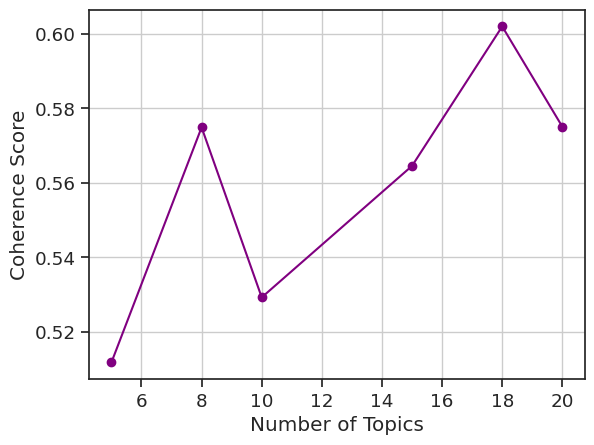

In [192]:
# Create a function to plot the average coherence for models with a different number of topics
def plot_coherence_scores(training_data, num_topics_list):
    # Create an empty list to append our coherence scores to
    coherence_scores = []

    # Create a loop that iterates over each element in the list
    for num_topics in num_topics_list:
        # Initialize the model
        model = tp.LDAModel(k=num_topics)

        # Add each document to the model, after splitting it up into words
        for text in training_data:
            model.add_doc(text.strip().split())

        # Train the model, iterate over the data 10 times
        iterations = 10
        for i in range(0, 100, iterations):
            model.train(iterations)

        # Calculate the coherence
        coh = tp.coherence.Coherence(model, coherence='c_v')
        average_coherence = coh.get_score()
        coherence_scores.append(average_coherence)

    # Plot the results in a line graph with dots to show how the coherence score changes
    plt.figure()
    plt.plot(num_topics_list, coherence_scores, marker='o', color='purple')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

# Call the function using some random number of topics
num_topics_list = [5, 8, 10, 15, 18, 20]
plot_coherence_scores(training_data, num_topics_list)

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [55]:
# Use Tomotpy to calculate the probability distribution
# The probability distributions presents the likelihood that each topic exists in the document.
topic_distributions = [list(doc.get_topic_dist()) for doc in model3.docs]

In [95]:
# Create a dictionary to store our lists 'original_texts' and 'titles'
trump_sanders_dict = dict(zip(original_texts, titles))

# Import markdown and display for the function
from IPython.display import Markdown, display

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):

    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics3[topic_index]

    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")

    for probability, doc in sorted_data[:n]:
        tweet_author = trump_sanders_dict[doc]
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        # Present the topic probability, tweet content, and author of the tweet
        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Tweet**: {doc}   \n**Author**: {tweet_author} \n\n')

    return

In [96]:
# Display 5 top tweets, their author, ID, and their topic probability

# Topics more likely associated with Sanders (I chose topic 1 and 12)
get_top_docs(original_texts, topic_distributions, topic_index=1, n=5)
get_top_docs(original_texts, topic_distributions, topic_index=12, n=5)

# Topics more likely associated with Trump (I chose topic 2, 14 and 9)
get_top_docs(original_texts, topic_distributions, topic_index=3, n=5)
get_top_docs(original_texts, topic_distributions, topic_index=16, n=5)
get_top_docs(original_texts, topic_distributions, topic_index=7, n=5)


### ✨Topic 1✨

change climate energy trump must fossil planet saudi fuel system



---


✨  
**Topic Probability**: 0.9285517334938049  
**Tweet**: I rise to oppose the nomination of Brett Kavanaugh to the Supreme Court: https://t.co/dLU6m3fGaX   
**Author**: SenSanders_1017099108568485888 



✨  
**Topic Probability**: 0.9225788116455078  
**Tweet**: I applaud Facebook co-founder Chris Hughes for sounding the alarm on the dangers of unchecked corporate power. We are living in an era of monopolies that dominate every aspect of our lives—including our government. It’s time to take that power back. https://t.co/L3eEofZtnh   
**Author**: SenSanders_1126848277083717632 



✨  
**Topic Probability**: 0.907766580581665  
**Tweet**: Trump said he wanted to get America out of wars. He lied.

When we passed a bipartisan bill to end illegal support for Saudi airstrikes in Yemen, he vetoed it.

Trump ignored the Constitution to keep helping this brutal dictatorship as it bombs civilians. https://t.co/RPMINmhO3F   
**Author**: SenSanders_1229857744880119808 



✨  
**Topic Probability**: 0.9021229147911072  
**Tweet**: Science is not Democratic or Republican, progressive or conservative. Congratulations to @ScienceMarchDC for fighting back.   
**Author**: SenSanders_824991505739808768 



✨  
**Topic Probability**: 0.890556275844574  
**Tweet**: Trickle-down economics is a fraud and we will not accept it. It is and it has always been an abysmal failure and a fraud.   
**Author**: SenSanders_848544336178491392 



### ✨Topic 12✨

workers tax billion pay million wage year dollars working time



---


✨  
**Topic Probability**: 0.941800594329834  
**Tweet**: The people of Venezuela are enduring a serious humanitarian crisis. The Maduro government must put the needs of its people first, allow humanitarian aid into the country, and refrain from violence against protesters.   
**Author**: SenSanders_1099380342018912256 



✨  
**Topic Probability**: 0.939855694770813  
**Tweet**: In the United States, you should not be in danger of losing your home because you get sick. We need to take on the greed of the pharmaceutical industry and lower drug prices. https://t.co/GCzcsbIKjn   
**Author**: SenSanders_1103467803309334528 



✨  
**Topic Probability**: 0.9305756092071533  
**Tweet**: While Amazon raised prices by up to 1,000% on masks, soap &amp; toilet paper, Jeff Bezos became $88 **billion** richer and continues to deny **workers** paid sick leave &amp; hazard **pay**. That is morally obscene. Billionaires should not be profiteering off a pandemic. #TaxTheRich   
**Author**: SenSanders_1304135025097617408 



✨  
**Topic Probability**: 0.9305756092071533  
**Tweet**: Tonight Trump—who in less than two years in the White House has seen 5 aides either plead guilty or be convicted of criminal charges—claimed the strength of the economy was dependent on him being free from necessary oversight and investigations. The exact opposite is true. #SOTU   
**Author**: SenSanders_1093002870188851200 



✨  
**Topic Probability**: 0.9305756092071533  
**Tweet**: Bills are piling up, rent is due, millions are jobless. A one-**time** $1,200 check won’t cut it.

We need to provide $2,000 a month to every man, woman and child—and make it retroactive to cover the past three months.

If we can bail out corporations, we can ensure everyone’s needs.   
**Author**: SenSanders_1270000771132731392 



### ✨Topic 3✨

border wall must security democrats country people immigration want illegal



---


✨  
**Topic Probability**: 0.920066237449646  
**Tweet**:  HAPPY NEW YEAR TO EVERYONE, INCLUDING THE HATERS AND THE FAKE NEWS MEDIA! 2019 WILL BE A FANTASTIC YEAR FOR THOSE NOT SUFFERING FROM TRUMP DERANGEMENT SYNDROME. JUST CALM DOWN AND ENJOY THE RIDE, GREAT THINGS ARE HAPPENING FOR OUR COUNTRY!   
**Author**: @realDonaldTrump_1080088373451206656 



✨  
**Topic Probability**: 0.9164202809333801  
**Tweet**:  The Democrats were trying mightily to revive the badly &amp; irrevocably tarnished Witch Hunt Hoax until Robert Mueller put on the greatest display of ineptitude &amp; incompetence that the Halls of Congress have ever seen. Truth is, he had no facts on his side. Nothing he could do!   
**Author**: @realDonaldTrump_1155210027025797121 



✨  
**Topic Probability**: 0.9053468108177185  
**Tweet**:  ....When I won the Election in 2016, the @nytimes had to beg their fleeing subscribers for forgiveness in that they covered the Election (and me) so badly. They didn’t have a clue, it was pathetic. They even apologized to me. But now they are even worse, really corrupt reporting!   
**Author**: @realDonaldTrump_1117210469629071360 



✨  
**Topic Probability**: 0.8985674381256104  
**Tweet**:  Mexico, whose laws on **immigration** are very tough, **must** stop **people** from going through Mexico and into the U.S. We may make this a condition of the new NAFTA Agreement. Our Country cannot accept what is happening! Also, we **must** get Wall funding fast.   
**Author**: @realDonaldTrump_988415011382091776 



✨  
**Topic Probability**: 0.8985674381256104  
**Tweet**:  Honduras, Mexico and many other countries that the U.S. is very generous to, sends many of their **people** to our **country** through our WEAK IMMIGRATION POLICIES. Caravans are heading here. Must pass tough laws and build the WALL. Democrats allow open borders, drugs and crime!   
**Author**: @realDonaldTrump_980961086546632705 



### ✨Topic 16✨

news fake media cnn new foxnews story people times even



---


✨  
**Topic Probability**: 0.9274262189865112  
**Tweet**:  I will be interviewed by @TuckerCarlson tonight at 8:00pm on @FoxNews!   
**Author**: @realDonaldTrump_1145819097395073024 



✨  
**Topic Probability**: 0.9243927001953125  
**Tweet**:  HAPPY GOOD FRIDAY TO ALL!   
**Author**: @realDonaldTrump_1248619884688199682 



✨  
**Topic Probability**: 0.8994116187095642  
**Tweet**:  In Florida there is a choice between a Harvard/Yale educated man named @RonDeSantisFL who has been a great Congressman and will be a great Governor - and a Dem who is a thief and who is Mayor of poorly run Tallahassee, said to be one of the most corrupt cities in the Country!   
**Author**: @realDonaldTrump_1056922209111994373 



✨  
**Topic Probability**: 0.8916513323783875  
**Tweet**:  Thank you. I love you too! https://t.co/4qwFlUHfn7   
**Author**: @realDonaldTrump_1234280791791865857 



✨  
**Topic Probability**: 0.8806906342506409  
**Tweet**:  The Washington Post is far more fiction than fact. Story after **story** is made up made garbage - more like a poorly written novel than good reporting. Always quoting sources (not names), many of which don’t exist. Story on John Kelly isn’t true...just another hit job!   
**Author**: @realDonaldTrump_982947260005781505 



### ✨Topic 7✨

jobs economy trump president record years ever best since year



---


✨  
**Topic Probability**: 0.930058479309082  
**Tweet**:  “The unemployment rate remains at a 17-**year** low of 4.1%. The unemployment rate in manufacturing dropped to 2.6%, the lowest **ever** recorded. The unemployment rate among Hispanics dropped to 4.7%, the lowest **ever** recorded...” @SecretaryAcosta @USDOL https://t.co/vou28s0yHN   
**Author**: @realDonaldTrump_939208571253862400 



✨  
**Topic Probability**: 0.902739405632019  
**Tweet**:  RT @mschlapp: .@PamBondi is disgusted by the socialist, big city mayors refusing to allow @realDonaldTrump to help protect American citizens as rioters run roughshod over their cities. Hear more from our conversation on today’s #CPACLive https://t.co/UKSVi6l2D2   
**Author**: @realDonaldTrump_1302094904173232128 



✨  
**Topic Probability**: 0.902739405632019  
**Tweet**:  RT @TomFitton: ICYMI: Mueller Report Was A Political Tool To Attack President @RealDonaldTrump https://t.co/cSuMc56cni via @JudicialWatch @WMALDC   
**Author**: @realDonaldTrump_1127182387694198784 



✨  
**Topic Probability**: 0.8928642272949219  
**Tweet**:  “Remarks by President Trump to the 73rd Session of the United Nations General Assembly” ➡️https://t.co/Oshhko61zY https://t.co/Fm8LSse417   
**Author**: @realDonaldTrump_1044637590719221762 



✨  
**Topic Probability**: 0.8928642272949219  
**Tweet**:  Watch @MariaBartiromo at 6:00 P.M. on @FoxBusiness. Russian Hoax the big topic! Mainstream Media, often referred to as the Fake News Media, hates to discuss the real facts!   
**Author**: @realDonaldTrump_1041441676949184512 



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

In [ ]:
# Q7b (words)


<font color=purple> **When going through the the topic list in question 5b, I already got a feeling which topics might have a strong relevance for Trump vs. Sanders. I tried to predict this by picking these topics for question 7a. As you can see, the two topics I picked for Senator Sanders only have top tweets by Sanders whilst the topics I picked for President Trump only include top tweets by Trump himself. For other topics, this might differ, having a more equal distribution.**

<font color=purple> **The reason why I thought these topics were probably going to match the person I was interested in has to do with some knowledge I have of both their campaigns and viewpoints. Considering my background in American Studies, but also the ideas shared at the beginning of this assignment about the difference between 'right-wing populists' and 'left-wing populists,' I picked these topics.**


<font color=purple> **The first topic that fits with Sanders is Topic 1, a topic revolving around various issues related to climate change. A topic more commonly connected to the left-wing and Bernie Sanders. The second topic that fits with this more left-wing populist outlook is Topic 12, which includes a focus on economics through the lens of workers, taxes, and income. This fits with the idea that "left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite," which is why I expected this topic to return to top tweets by Sanders mainly.**

<font color=purple> **For Trump, I chose 3 topics that I expected to return the top tweets by Trump's Twitter. The first one is Topic 3, which focuses on discussions around immigration and border security. This fits with the earlier defined idea that "right-wing populism often emphasizes nationalism [and]anti-immigration policies..." Furthermore, considering the right-wing populist, and most famously Trump's, critique on the 'mainstream' media, I also expected topic 15 to return top hits for Trump, as this topic focuses on 'fake media,' including some keywords of well-known media channels which Trump has critiques, or praised. Finally, I was interested if Topic 7 with a focus on jobs and the economy, which is an area of concern also shared by left-wing populists, would return top hits for Trump only, as it talks about 'record,' 'best,' 'ever', and 'trump'. Although it returned 5 top Trump tweets, only the first of these seems to really fit the topic and my expectations.**

<font color=purple> **However, this is a larger concern in the top tweets revealed above that I wanted to mention. Although the outcome fits my expectations concerning the division of topics between left-wing populist Sanders and right-wing populist Trump, the actual content of the top tweets are not very clearly aligned with the 'overall' topic. Only some include the keywords or are easily identifiable with the topic. This makes me curious for more exploration, for example, selecting more than five top tweets, in a further analysis.**

## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [97]:
# Create a sample of tweets

from random import sample

target_labels = sample(titles,100)

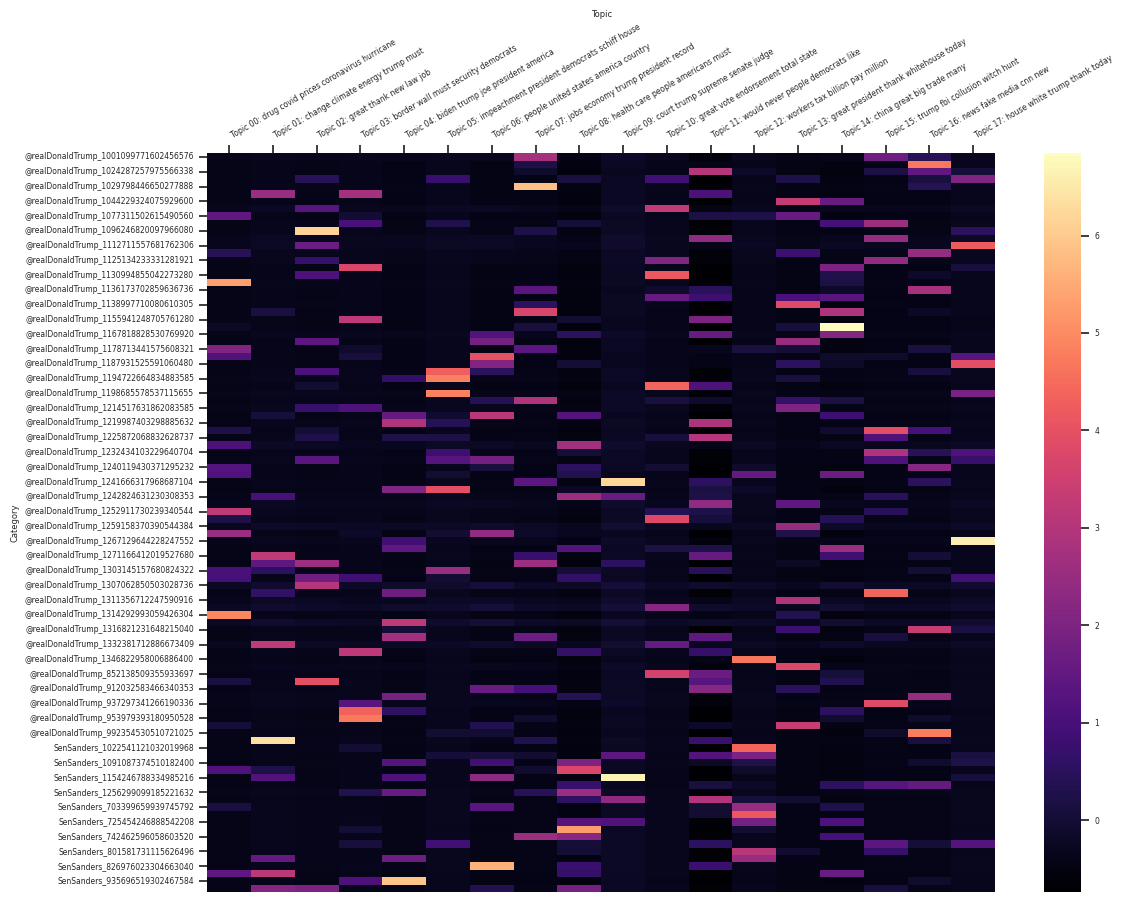

In [111]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()

# Create a function to plot our topics with a heatmap visualization, change the font_scale to 0.5 for clearer visuals.
sns.set(style='ticks', font_scale=0.5)
def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})


    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

    # Show the final plot, again change the font_scale to 0.5 for clearer visuals.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=0.5)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

# Plot the random sample data in a heatmap, use the color map magma for a clear visualization
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words3,
                                  target_labels=target_labels,
                                  color_map = 'magma',
                                 dim=(12,9))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

In [ ]:
# Q9 (words)

<font color=purple> **The lighter the color in this heatmap (moving from black and purple, to lighter purple, pink, orange, and yellow) represents a high probability for a match with the corresponding topic, compared to the other sample tweets in this heatmap.**

<font color=purple> **Picking out the yellow blocks, we can say that topics 1, 4, 8, and 12 are more probable for Senator Sanders to tweet about, whilst for President Trump, this includes topics 0, 2, 3, 5, 7, 10, 13, 14, 15, 16, and 17. The list for Trump is a lot longer, which is probably motivated by the larger size of Trump tweets in this sample than those of Sanders. However, by considering the topics in a similar way to question 7b, these largely seem to fit the idea of left-wing vs. right-wing populism, as well as more specific topics related to Trump.**

<font color=purple> **Topics 6 and 9 seem to be likely for both Trump and Sanders, showing some overlap in their concern for the people, fitting with populism in general, as well as the appointment of Supreme Court judges, which is relevant to both sides of the political spectrum; one-side presenting support for the new appointment, whilst the other side is probably critiquing Trump's choice.**


### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [126]:
# Separate titles into Trump and Sanders
trump_titles = [title for title in titles if '@realDonaldTrump' in title]
sanders_titles = [title for title in titles if 'SenSanders' in title]

# Sample 50 titles from each list
sampled_trump_titles = sample(trump_titles, 50)
sampled_sanders_titles = sample(sanders_titles, 50)

# Combine sampled titles into a single list
balanced_sample = sampled_trump_titles + sampled_sanders_titles

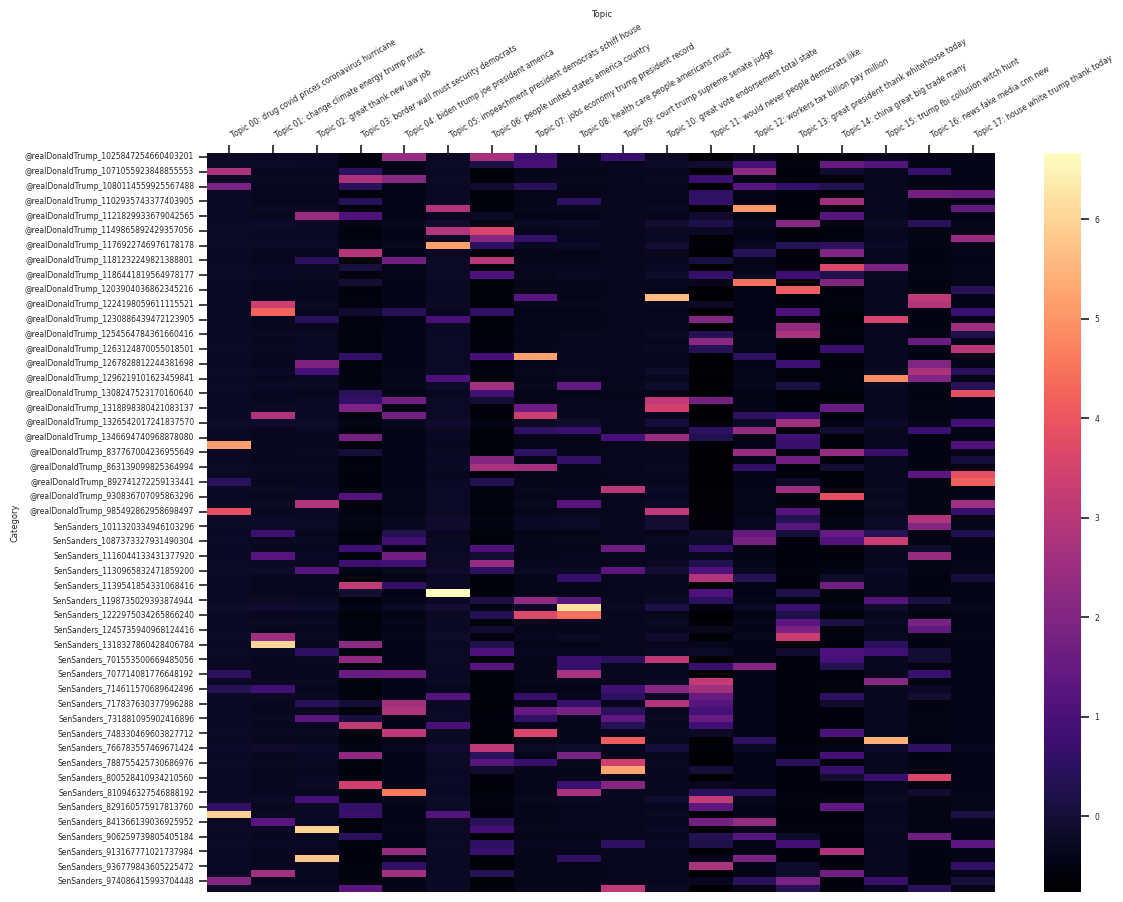

In [127]:
# Plot the balanced sample data in a heatmap, use the color map magma for a clear visualization
plot_categories_by_topics_heatmap(balanced_sample,
                                  topic_distributions,
                                  topic_individual_words3,
                                  target_labels=balanced_sample,
                                  color_map = 'magma',
                                 dim=(12,9))

<font color=purple>**The heatmap now represents an equal sample of Trump and Sanders tweets, making it more comparable. There seem to be slightly more lighter colors in opposition to the earlier heatmap as well, indicating a clearer division of the topics most likely.**

### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [182]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)

<font color=purple> **This question feels a bit more open to interpretation, so I decided to build upon our earlier code but make sure it includes all our data as well as a clear division between Trump and Sanders for a comparative analysis.**
<font color=purple> **As presenting a heatmap for 30341 lines is not very practical, I made sure to work with averages by calculating the mean of Trump's Tweets and Sanders's Tweets.**

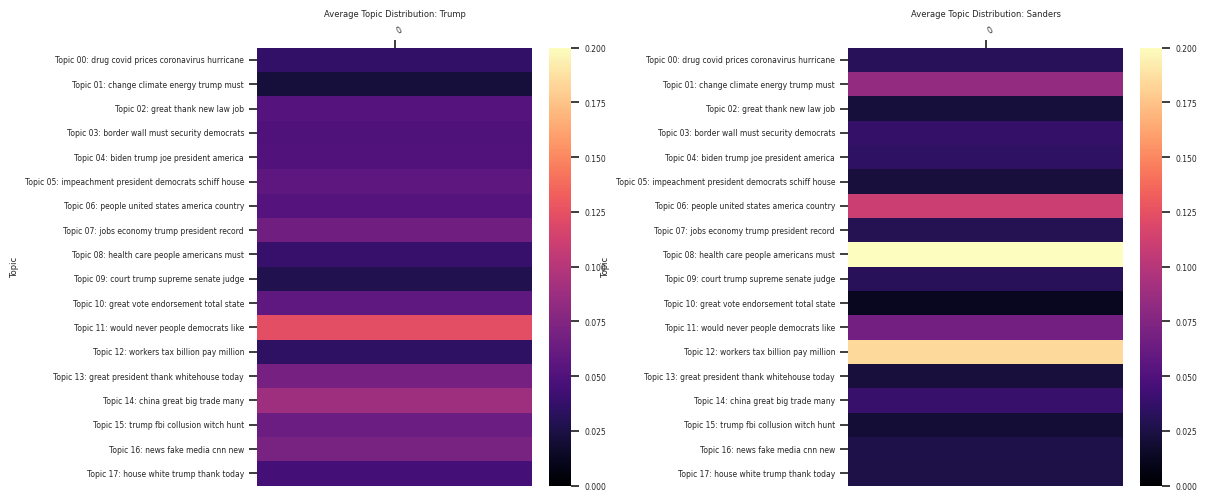

In [280]:
# Create a function to plot our topics with a heatmap visualization, change the font_scale to 0.5 for clearer visuals.
sns.set(style='ticks', font_scale=0.5)
def plot_extended_trump_sanders_heatmap(labels,
                                        topic_distributions,
                                        topic_keys,
                                        output_path=None,
                                        color_map = sns.cm.rocket_r,
                                        dim=None):

    # Combine the labels and distributions into a list of dictionaries, remove the earlier conditional statement (no sample data)
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
      for _topic_index, _probability in enumerate(_distribution):
        dicts_to_plot.append({'Probability': float(_probability),
                              'Category': _label,
                              'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')

    # Split the dataframe into Sanders and Trump categories for an interesting comparative analysis including the whole dataset
    # https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html
    tweets_trump = df_wide[df_wide.index.str.contains('@realDonaldTrump')]
    tweets_sanders = df_wide[df_wide.index.str.contains('SenSanders')]

    # Calculate mean values for each topic separately for Sanders and Trump, this will give us an average score for both politicans on each topics
    topic_means_trump = tweets_trump.mean()
    topic_means_sanders = tweets_sanders.mean()

    # Plot the heatmaps
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=0.5)

    # Create a subplot for Trump's heatmap, make sure the mean is compatible for visualization and include the same max for both.
    # https://www.w3schools.com/python/matplotlib_subplot.asp
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.to_frame.html
    plt.subplot(1, 2, 1)
    ax1 = sns.heatmap(topic_means_trump.to_frame(), cmap=color_map, vmin = 0, vmax = 0.2)
    ax1.set_title('Average Topic Distribution: Trump')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')

    # Create a subplot for Sanders's heatmap, make sure the mean is compatible for visualization and include the same max for both.
    # https://www.w3schools.com/python/matplotlib_subplot.asp
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.to_frame.html
    plt.subplot(1, 2, 2)
    ax2 = sns.heatmap(topic_means_sanders.to_frame(), cmap=color_map, vmin = 0, vmax = 0.2)
    ax2.set_title('Average Topic Distribution: Sanders')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')

    # Showcase the plot
    plt.tight_layout()
    plt.show()

# Plot the data in a heatmap, use the color map magma for a clear visualization
plot_extended_trump_sanders_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words3,
                                  color_map = 'magma',
                                  dim=(12,5))

<font color=purple> **The visualization above gives us a nice representation of how the topics are divided. For Trump, topics 11, 14, 7, and 16 are the lightest, indicating a higher score, whilst for Sanders topic 8, 12, 6 and 1 are the lightest. This fits with some of our earlier findings of the topics which both politicians are more concerned with. For Trump this is the media, china, trade, jobs/records, and critiquing the democratic party. For Sanders, the topics are more concerned with taxes, health care, climate change, and the people.**
